In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray/'
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')
val_dir = os.path.join(data_dir, 'val')

In [5]:
for dir_name in ['train', 'test', 'val']:
    for category in ['NORMAL', 'PNEUMONIA']:
        category_dir = os.path.join(data_dir, dir_name, category)
        num_images = len(os.listdir(category_dir))
        print(f'{dir_name}/{category}: {num_images} images')

train/NORMAL: 1341 images
train/PNEUMONIA: 3875 images
test/NORMAL: 234 images
test/PNEUMONIA: 390 images
val/NORMAL: 8 images
val/PNEUMONIA: 8 images


In [6]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0, 
    rotation_range=20,  
    width_shift_range=0.2, 
    height_shift_range=0.2,  
    shear_range=0.2,  
    zoom_range=0.2,  
    horizontal_flip=True,  
    fill_mode='nearest'  
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'  
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


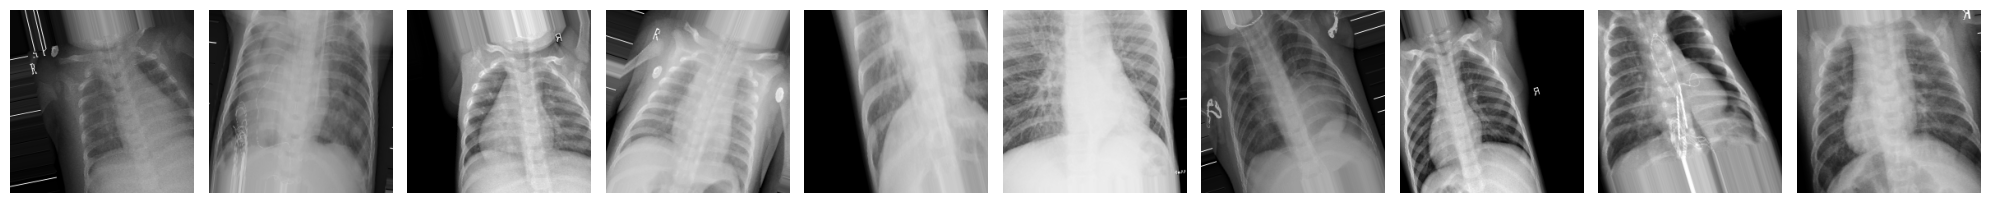

In [7]:
def plot_images(images_arr):
    fig, axes = plt.subplots(1, 10, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()
    plt.show()

images, i = next(train_generator)
plot_images(images[:10])

In [8]:
import tensorflow as tf
from tensorflow.keras import layers, models

# Define the encoder
def build_encoder(input_shape=(224, 224, 3)):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    latent_space = layers.MaxPooling2D((2, 2), padding='same')(x)
    return models.Model(inputs, latent_space, name='encoder')

# Define the decoder
def build_decoder(latent_shape):
    latent_inputs = layers.Input(shape=latent_shape)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(latent_inputs)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2D(3, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')




In [9]:
# Build the autoencoder
input_shape = (224, 224, 3)
encoder = build_encoder(input_shape)
latent_shape = encoder.output_shape[1:]
decoder = build_decoder(latent_shape)

autoencoder = models.Model(encoder.input, decoder(encoder.output), name='autoencoder')

# Print model summaries
encoder.summary()
decoder.summary()
autoencoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 93,248 (364.25 KB)

 Trainable params: 93,248 (364.25 KB)

 Non-trainable params: 0 (0.00 B)

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)      │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 56, 56, 64)     │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 112, 112, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_2 (UpSampling2D)  │ (None, 224, 224, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 224, 224, 3)    │           867 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 240,707 (940.26 KB)

 Trainable params: 240,707 (940.26 KB)

 Non-trainable params: 0 (0.00 B)

Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 224, 224, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 112, 112, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 56, 56, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 28, 28, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 224, 224, 3)    │       240,707 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 333,955 (1.27 MB)

 Trainable params: 333,955 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 719s 4s/step - loss: 0.0242 - val_loss: 0.0028
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - loss: 0.0021 - val_loss: 0.0022
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 716s 4s/step - loss: 0.0016 - val_loss: 0.0021
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - loss: 0.0012 - val_loss: 0.0020
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 721s 4s/step - loss: 0.0011 - val_loss: 0.0017
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 719s 4s/step - loss: 0.0010 - val_loss: 0.0016
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 727s 4s/step - loss: 9.6428e-04 - val_loss: 0.0016
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 715s 4s/step - loss: 8.7367e-04 - val_loss: 0.0015
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - loss: 7.8701e-04 - val_loss: 0.0017
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 713s 4s/step - loss: 8.1884e-04 - val_los

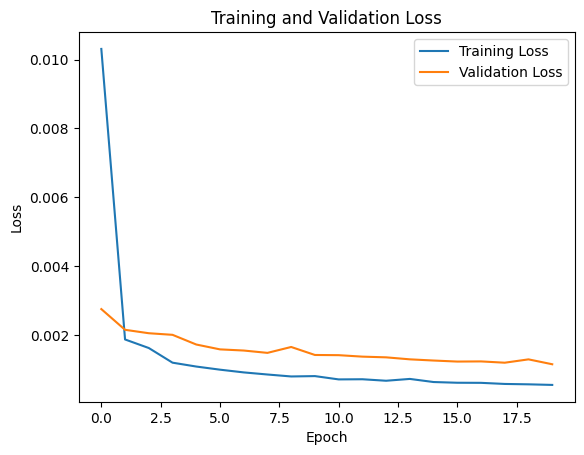

In [10]:
# Update the ImageDataGenerators for the autoencoder
train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,  # Normalize pixel values
    rotation_range=20,  # Rotate images up to 20 degrees
    width_shift_range=0.2,  # Shift images horizontally by 20%
    height_shift_range=0.2,  # Shift images vertically by 20%
    shear_range=0.2,  # Shear images by 20%
    zoom_range=0.2,  # Zoom into images by 20%
    horizontal_flip=True,  # Flip images horizontally
    fill_mode='nearest'  # Fill in new pixels with the nearest pixel value
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # Set class_mode to None for autoencoder
    shuffle=True
)

val_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # Set class_mode to None for autoencoder
    shuffle=True
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode=None,  # Set class_mode to None for autoencoder
    shuffle=True
)

# Ensure the data generator outputs batches of the correct shape
def preprocess_data(data_generator):
    while True:
        x_batch = data_generator.__next__()
        yield x_batch, x_batch

train_data = preprocess_data(train_generator)
val_data = preprocess_data(val_generator)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Training the autoencoder
history = autoencoder.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Adjust the number of epochs as needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 173s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 504ms/step
20/20 ━━━━━━━━━━━━━━━━━━━━ 15s 725ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


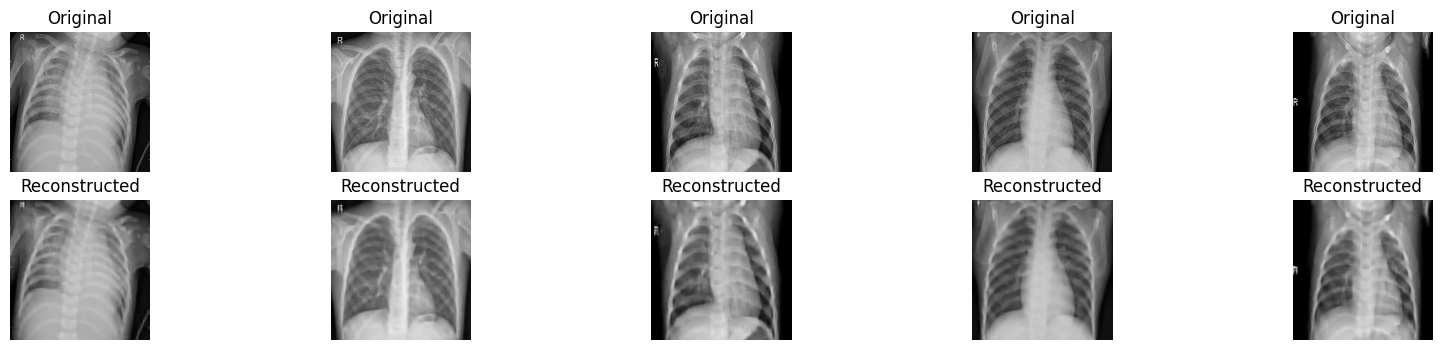

In [11]:
# Extract features from the latent space
train_features = encoder.predict(train_generator)
val_features = encoder.predict(val_generator)
test_features = encoder.predict(test_generator)

# Display a few examples of the original and reconstructed images
def display_reconstructed_images(model, data_generator, n_images=5):
    data_generator.reset()
    images = next(data_generator)
    reconstructed_images = model.predict(images)

    plt.figure(figsize=(20, 4))
    for i in range(n_images):
        # Original images
        ax = plt.subplot(2, n_images, i + 1)
        plt.imshow(images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(2, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")
    plt.show()

# Display original and reconstructed images
display_reconstructed_images(autoencoder, test_generator, n_images=5)


In [12]:
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K

# Define the sampling layer
class Sampling(layers.Layer):
    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

# Define the encoder
def build_encoder(input_shape=(224, 224, 3), latent_dim=64):
    inputs = layers.Input(shape=input_shape)
    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.MaxPooling2D((2, 2), padding='same')(x)
    x = layers.Flatten()(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    return models.Model(inputs, [z_mean, z_log_var, z], name='encoder')

# Define the decoder
def build_decoder(latent_dim=64, output_shape=(224, 224, 3)):
    latent_inputs = layers.Input(shape=(latent_dim,))
    x = layers.Dense(28*28*128, activation='relu')(latent_inputs)
    x = layers.Reshape((28, 28, 128))(x)
    x = layers.Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    x = layers.Conv2DTranspose(32, (3, 3), activation='relu', padding='same')(x)
    x = layers.UpSampling2D((2, 2))(x)
    outputs = layers.Conv2DTranspose(3, (3, 3), activation='sigmoid', padding='same')(x)
    return models.Model(latent_inputs, outputs, name='decoder')

# Build the VAE
input_shape = (224, 224, 3)
latent_dim = 64
encoder = build_encoder(input_shape, latent_dim)
decoder = build_decoder(latent_dim, input_shape)
z_mean, z_log_var, z = encoder.output
reconstructed = decoder(z)

# Define the custom VAE layer
class VAELossLayer(layers.Layer):
    def call(self, inputs, reconstructed, z_mean, z_log_var):
        reconstruction_loss_fn = tf.keras.losses.MeanSquaredError()
        reconstruction_loss = reconstruction_loss_fn(K.flatten(inputs), K.flatten(reconstructed))
        reconstruction_loss *= input_shape[0] * input_shape[1] * input_shape[2]
        kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
        kl_loss = K.sum(kl_loss, axis=-1)
        kl_loss *= -0.5
        total_loss = K.mean(reconstruction_loss + kl_loss)
        self.add_loss(total_loss)
        return reconstructed

# Apply the custom VAE loss layer
outputs = VAELossLayer()(encoder.input, reconstructed, z_mean, z_log_var)
vae = models.Model(encoder.input, outputs, name='vae')

# Compile the VAE
vae.compile(optimizer='adam')
vae.summary()


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 224, 224,  │        896 │ input_layer_4[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 112, 112,  │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 112, 112,  │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 56, 56,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 56, 56,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 28, 28,    │          0 │ conv2d_9[0][0]    │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 100352)    │          0 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 64)        │  6,422,592 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_log_var (Dense)   │ (None, 64)        │  6,422,592 │ flatten_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sampling (Sampling) │ (None, 64)        │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 224, 224,  │  6,763,587 │ sampling[0][0]    │
│ (Functional)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vae_loss_layer      │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (VAELossLayer)      │ 3)                │            │ decoder[0][0],    │
│                     │                   │            │ z_mean[0][0],     │
│                     │                   │            │ z_log_var[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,702,019 (75.16 MB)

 Trainable params: 19,702,019 (75.16 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 648s 4s/step - loss: 4996.6885 - val_loss: 1723.9409
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 650s 4s/step - loss: 1600.7098 - val_loss: 1285.9894
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 649s 4s/step - loss: 1211.7773 - val_loss: 1121.8993
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - loss: 1073.5515 - val_loss: 1018.0006
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - loss: 996.0198 - val_loss: 981.2692
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 651s 4s/step - loss: 958.3175 - val_loss: 941.4454
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - loss: 932.9639 - val_loss: 897.8539
Epoch 8/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 644s 4s/step - loss: 878.9337 - val_loss: 874.6136
Epoch 9/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 643s 4s/step - loss: 847.9934 - val_loss: 867.8036
Epoch 10/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 645s 4s/step - loss: 848.3776 - val_loss: 855.7578
Epoch 11/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 652s 4s/step - loss: 811.2080 - val_loss

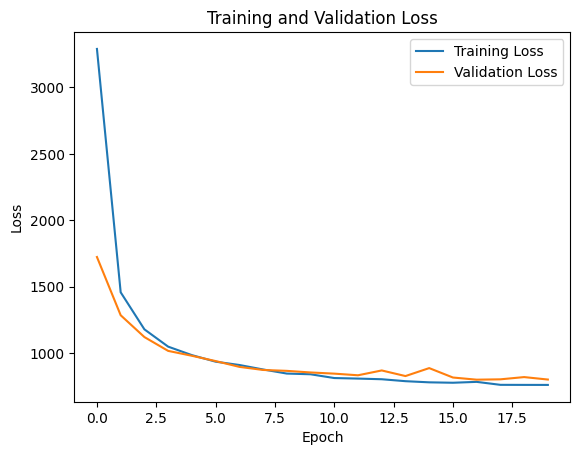

In [13]:
# Ensure the data generator outputs batches of the correct shape
def preprocess_data(data_generator):
    while True:
        x_batch = next(data_generator)
        yield x_batch, x_batch

train_data = preprocess_data(train_generator)
val_data = preprocess_data(val_generator)

# Training the VAE
history = vae.fit(
    train_data,
    validation_data=val_data,
    epochs=20,  # Adjust the number of epochs as needed
    steps_per_epoch=len(train_generator),
    validation_steps=len(val_generator)
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


20/20 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step


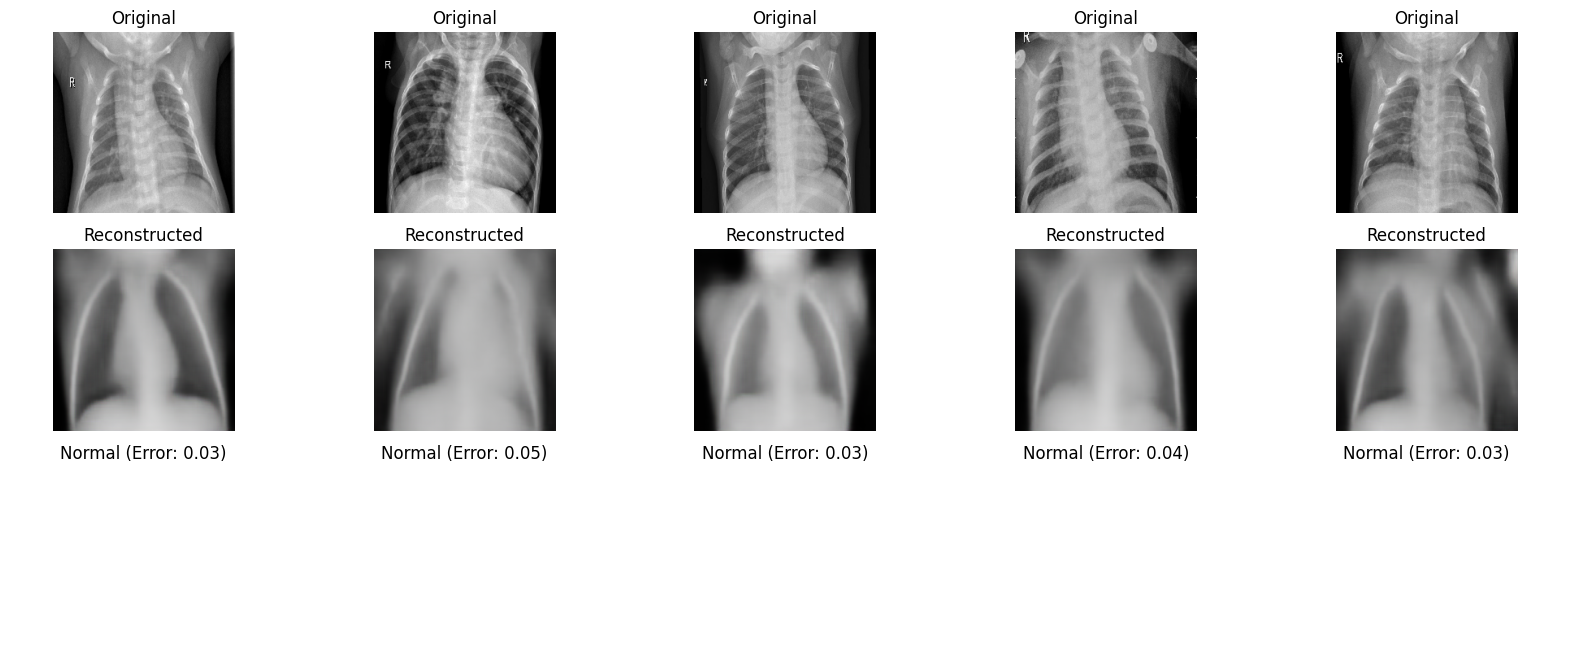

In [14]:
# Reconstruct the entire test dataset
test_data = preprocess_data(test_generator)
reconstructed_images = vae.predict(test_data, steps=len(test_generator), verbose=1)

# Get the original images from the test generator
test_generator.reset()
original_images = []
for _ in range(len(test_generator)):
    original_images.extend(next(test_generator))

original_images = np.array(original_images)

# Ensure original and reconstructed images have the same shape
original_images = original_images[:len(reconstructed_images)]

# Evaluate the reconstruction error
reconstruction_errors = np.mean(np.square(original_images - reconstructed_images), axis=(1, 2, 3))

# Identify anomalies based on high reconstruction errors
threshold = np.percentile(reconstruction_errors, 95)  # Set a threshold for anomaly detection
anomalies = reconstruction_errors > threshold

# Display a few examples of the original and reconstructed images with their reconstruction errors
def display_anomalies(original_images, reconstructed_images, reconstruction_errors, threshold, n_images=5):
    plt.figure(figsize=(20, 8))
    for i in range(n_images):
        # Original images
        ax = plt.subplot(3, n_images, i + 1)
        plt.imshow(original_images[i])
        plt.title("Original")
        plt.axis("off")

        # Reconstructed images
        ax = plt.subplot(3, n_images, i + 1 + n_images)
        plt.imshow(reconstructed_images[i])
        plt.title("Reconstructed")
        plt.axis("off")

        # Reconstruction error
        ax = plt.subplot(3, n_images, i + 1 + 2*n_images)
        error = reconstruction_errors[i]
        if error > threshold:
            plt.title(f"Anomaly (Error: {error:.2f})")
        else:
            plt.title(f"Normal (Error: {error:.2f})")
        plt.axis("off")

    plt.show()

# Display anomalies
display_anomalies(original_images, reconstructed_images, reconstruction_errors, threshold, n_images=5)


In [15]:
import os
import shutil
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [16]:
import os
import shutil
import random

# Define directories
data_dir = '/kaggle/input/chest-xray-pneumonia/chest_xray'
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Define writable directories
balanced_data_dir = '/kaggle/working/balanced_chest_xray'
balanced_train_dir = os.path.join(balanced_data_dir, 'train')
balanced_val_dir = os.path.join(balanced_data_dir, 'val')

# Create directories if they do not exist
os.makedirs(balanced_train_dir, exist_ok=True)
os.makedirs(balanced_val_dir, exist_ok=True)

# Create subdirectories for each category
for category in ['NORMAL', 'PNEUMONIA']:
    os.makedirs(os.path.join(balanced_train_dir, category), exist_ok=True)
    os.makedirs(os.path.join(balanced_val_dir, category), exist_ok=True)

# Function to copy files
def copy_files(src_dir, dst_dir, file_list):
    for file_name in file_list:
        shutil.copy(os.path.join(src_dir, file_name), os.path.join(dst_dir, file_name))

# Move a subset of images from train to val
num_images_to_move = 250
for category in ['NORMAL', 'PNEUMONIA']:
    train_images = os.listdir(os.path.join(train_dir, category))
    images_to_move = random.sample(train_images, num_images_to_move)
    copy_files(os.path.join(train_dir, category), os.path.join(balanced_val_dir, category), images_to_move)
    remaining_images = [img for img in train_images if img not in images_to_move]
    copy_files(os.path.join(train_dir, category), os.path.join(balanced_train_dir, category), remaining_images)

# Copy original validation images to the new validation set
for category in ['NORMAL', 'PNEUMONIA']:
    val_images = os.listdir(os.path.join(val_dir, category))
    copy_files(os.path.join(val_dir, category), os.path.join(balanced_val_dir, category), val_images)

# Check the new distribution
balanced_train_normal = len(os.listdir(os.path.join(balanced_train_dir, 'NORMAL')))
balanced_train_pneumonia = len(os.listdir(os.path.join(balanced_train_dir, 'PNEUMONIA')))
balanced_val_normal = len(os.listdir(os.path.join(balanced_val_dir, 'NORMAL')))
balanced_val_pneumonia = len(os.listdir(os.path.join(balanced_val_dir, 'PNEUMONIA')))

print(f"Balanced Training set: Normal - {balanced_train_normal}, Pneumonia - {balanced_train_pneumonia}")
print(f"Balanced Validation set: Normal - {balanced_val_normal}, Pneumonia - {balanced_val_pneumonia}")


Balanced Training set: Normal - 1091, Pneumonia - 3625
Balanced Validation set: Normal - 258, Pneumonia - 258


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_size = (224, 224)
batch_size = 32

train_datagen = ImageDataGenerator(
    rescale=1.0/255.0,
    rotation_range=50,
    width_shift_range=0.5,
    height_shift_range=0.5,
    shear_range=0.5,
    zoom_range=0.5,
    horizontal_flip=True,
    fill_mode='nearest'
)

val_test_datagen = ImageDataGenerator(rescale=1.0/255.0)

train_generator = train_datagen.flow_from_directory(
    balanced_train_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

val_generator = val_test_datagen.flow_from_directory(
    balanced_val_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='binary',
    shuffle=False
)

# Calculate steps per epoch
train_steps_per_epoch = train_generator.samples // train_generator.batch_size
val_steps = val_generator.samples // val_generator.batch_size
test_steps = test_generator.samples // test_generator.batch_size

print(f"Training steps per epoch: {train_steps_per_epoch}")
print(f"Validation steps: {val_steps}")
print(f"Test steps: {test_steps}")


Found 4716 images belonging to 2 classes.
Found 516 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Training steps per epoch: 147
Validation steps: 16
Test steps: 19


In [18]:
# Repeat the datasets to ensure they have enough data for each epoch
train_dataset = tf.data.Dataset.from_generator(
    lambda: train_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()

val_dataset = tf.data.Dataset.from_generator(
    lambda: val_generator,
    output_signature=(
        tf.TensorSpec(shape=(None, image_size[0], image_size[1], 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.float32)
    )
).repeat()


In [19]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers

def mlp(x, hidden_units, dropout_rate, l2_reg=0.01):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu, kernel_regularizer=regularizers.l2(l2_reg))(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

def build_vit(input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, num_classes):
    inputs = layers.Input(shape=input_shape)
    patches = Patches(patch_size)(inputs)
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)
    for _ in range(transformer_layers):
        x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=projection_dim, dropout=0.3)(x1, x1)
        x2 = layers.Add()([attention_output, encoded_patches])
        x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.3, l2_reg=0.01)
        encoded_patches = layers.Add()([x3, x2])
    representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = layers.Flatten()(representation)
    representation = layers.Dropout(0.5)(representation)
    features = mlp(representation, hidden_units=transformer_units, dropout_rate=0.5, l2_reg=0.01)
    logits = layers.Dense(num_classes)(features)
    model = tf.keras.Model(inputs=inputs, outputs=logits)
    return model

class Patches(layers.Layer):
    def __init__(self, patch_size):
        super(Patches, self).__init__()
        self.patch_size = patch_size

    def call(self, images):
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            strides=[1, self.patch_size, self.patch_size, 1],
            rates=[1, 1, 1, 1],
            padding='VALID',
        )
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, -1, patch_dims])
        return patches

# Define PatchEncoder layer
class PatchEncoder(layers.Layer):
    def __init__(self, num_patches, projection_dim):
        super(PatchEncoder, self).__init__()
        self.num_patches = num_patches
        self.projection = layers.Dense(units=projection_dim)
        self.position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )

    def call(self, patches):
        positions = tf.range(start=0, limit=self.num_patches, delta=1)
        encoded = self.projection(patches) + self.position_embedding(positions)
        return encoded


input_shape = (224, 224, 3)
patch_size = 16
num_patches = (input_shape[0] // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [projection_dim * 2, projection_dim]
transformer_layers = 8
num_classes = 2

vit_model = build_vit(
    input_shape, patch_size, num_patches, projection_dim, num_heads, transformer_units, transformer_layers, num_classes
)
vit_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), 
                  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
                  metrics=['accuracy'])

vit_model.summary()

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
callbacks = [early_stopping, reduce_lr]


Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patches_2 (Patches) │ (None, None, 768) │          0 │ input_layer_6[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_encoder_2     │ (None, 196, 64)   │     61,760 │ patches_2[0][0]   │
│ (PatchEncoder)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ patch_encoder_2[… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ patch_encoder_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_42 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_55          │ (None, 196, 128)  │          0 │ dense_42[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 196, 64)   │      8,256 │ dropout_55[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_56          │ (None, 196, 64)   │          0 │ dense_43[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 196, 64)   │          0 │ dropout_56[0][0], │
│                     │                   │            │ add_32[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │     66,368 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_33[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_58          │ (None, 196, 128)  │          0 │ dense_44[0][0]    │
│ (Dropout)           │                   │            │                 

 Total params: 2,341,634 (8.93 MB)

 Trainable params: 2,341,634 (8.93 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 340s 2s/step - accuracy: 0.6646 - loss: 17.6646 - val_accuracy: 0.5000 - val_loss: 16.6038 - learning_rate: 1.0000e-04
Epoch 2/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 321s 2s/step - accuracy: 0.7132 - loss: 16.0238 - val_accuracy: 0.5021 - val_loss: 14.9752 - learning_rate: 1.0000e-04
Epoch 3/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 299s 2s/step - accuracy: 0.7260 - loss: 14.3518 - val_accuracy: 0.5041 - val_loss: 13.3528 - learning_rate: 1.0000e-04
Epoch 4/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 300s 2s/step - accuracy: 0.7450 - loss: 12.6678 - val_accuracy: 0.4876 - val_loss: 11.8548 - learning_rate: 1.0000e-04
Epoch 5/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/step - accuracy: 0.7602 - loss: 11.0948 - val_accuracy: 0.5620 - val_loss: 10.1674 - learning_rate: 1.0000e-04
Epoch 6/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 298s 2s/step - accuracy: 0.7600 - loss: 9.6145 - val_accuracy: 0.5103 - val_loss: 8.9252 - learning_rate: 1.0000e-04
Epoch 7/50
147/147 ━━━━━━━━━━━━━━━━━━━━ 296s 2s/

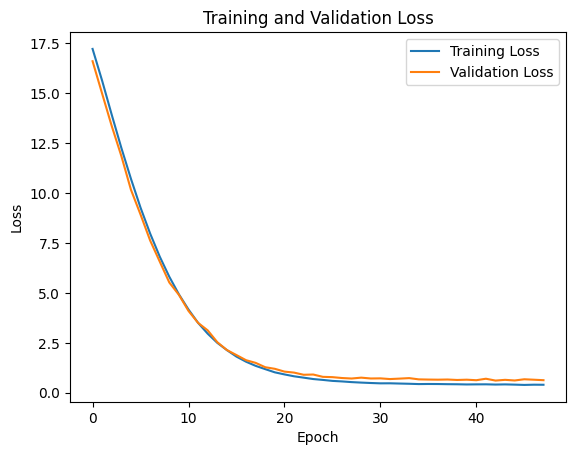

In [20]:
import matplotlib.pyplot as plt

# Training the Vision Transformer
history = vit_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    steps_per_epoch=train_steps_per_epoch,
    validation_steps=val_steps,
    callbacks=callbacks
)

# Plot training history
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [21]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Evaluate the model on the test set
test_steps = test_generator.samples // test_generator.batch_size

# Predictions
predictions = vit_model.predict(test_generator, steps=test_steps)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = test_generator.classes[:len(predicted_classes)]
class_labels = list(test_generator.class_indices.keys())

accuracy = accuracy_score(true_classes, predicted_classes)
precision = precision_score(true_classes, predicted_classes, average='weighted')
recall = recall_score(true_classes, predicted_classes, average='weighted')
f1 = f1_score(true_classes, predicted_classes, average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Test Precision: {precision}")
print(f"Test Recall: {recall}")
print(f"Test F1 Score: {f1}")


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


19/19 ━━━━━━━━━━━━━━━━━━━━ 17s 746ms/step
Test Accuracy: 0.6101973684210527
Test Precision: 0.6092687938196105
Test Recall: 0.6101973684210527
Test F1 Score: 0.6097185077508427


In [22]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, mean_squared_error

# Function to evaluate autoencoder and VAE reconstruction quality
def evaluate_reconstruction_quality(original_images, reconstructed_images):
    mse = mean_squared_error(original_images.flatten(), reconstructed_images.flatten())
    return mse

# Function to evaluate classification models
def evaluate_classification_model(model, data_generator):
    data_generator.reset()
    predictions = model.predict(data_generator, steps=len(data_generator))
    predicted_classes = np.argmax(predictions, axis=1)
    true_classes = data_generator.classes

    accuracy = accuracy_score(true_classes, predicted_classes)
    precision = precision_score(true_classes, predicted_classes, average='weighted')
    recall = recall_score(true_classes, predicted_classes, average='weighted')
    f1 = f1_score(true_classes, predicted_classes, average='weighted')
    
    return accuracy, precision, recall, f1


In [23]:
# Autoencoder reconstruction quality
original_images, _ = next(test_generator)
reconstructed_images = autoencoder.predict(original_images)
autoencoder_mse = evaluate_reconstruction_quality(original_images, reconstructed_images)
print(f"Autoencoder Reconstruction MSE: {autoencoder_mse}")

# VAE reconstruction quality
reconstructed_images = vae.predict(original_images)
vae_mse = evaluate_reconstruction_quality(original_images, reconstructed_images)
print(f"VAE Reconstruction MSE: {vae_mse}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Autoencoder Reconstruction MSE: 0.0011287359520792961
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
VAE Reconstruction MSE: 0.006218443624675274


In [24]:
# Evaluate Vision Transformer
vit_accuracy, vit_precision, vit_recall, vit_f1 = evaluate_classification_model(vit_model, test_generator)
print(f"Vision Transformer Test Accuracy: {vit_accuracy}")
print(f"Vision Transformer Test Precision: {vit_precision}")
print(f"Vision Transformer Test Recall: {vit_recall}")
print(f"Vision Transformer Test F1 Score: {vit_f1}")

20/20 ━━━━━━━━━━━━━━━━━━━━ 16s 781ms/step
Vision Transformer Test Accuracy: 0.6153846153846154
Vision Transformer Test Precision: 0.6153846153846154
Vision Transformer Test Recall: 0.6153846153846154
Vision Transformer Test F1 Score: 0.6153846153846154
